In [1]:
%reload_ext autoreload
%autoreload 2

import os
import datetime as dt
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config Inlinebackend.figure_format = 'retina'

In [2]:
# Constants

# Filepath
FILE_PATH = "/Users/lukasmalms/Desktop/DataScience/GitHub/german-power-grid/data/de-50hertz-demand-data.csv"

# Timezone
UTC = pytz.utc

In [3]:
# Import data
df = pd.read_csv(
    filepath_or_buffer=FILE_PATH, 
    index_col="timestamp",
    parse_dates=True
).astype(
    {"quantity": float}
).rename(columns=
    {"quantity": "local_demand"}
)

# Set frequency
df.index.freq = df.index.inferred_freq

# View head
df.head()

,local_demand
timestamp,
2015-01-01 00:00:00+00:00,9080.0
2015-01-01 00:15:00+00:00,9021.0
2015-01-01 00:30:00+00:00,8922.0
2015-01-01 00:45:00+00:00,8902.0
2015-01-01 01:00:00+00:00,8855.0


## EDA

In [4]:
# Missing data?
print(df.reset_index().isna().any(axis=0))

timestamp       False
local_demand    False
dtype: bool


In [5]:
# Duplicate data?
df.loc[df.index.duplicated()]

,local_demand
timestamp,


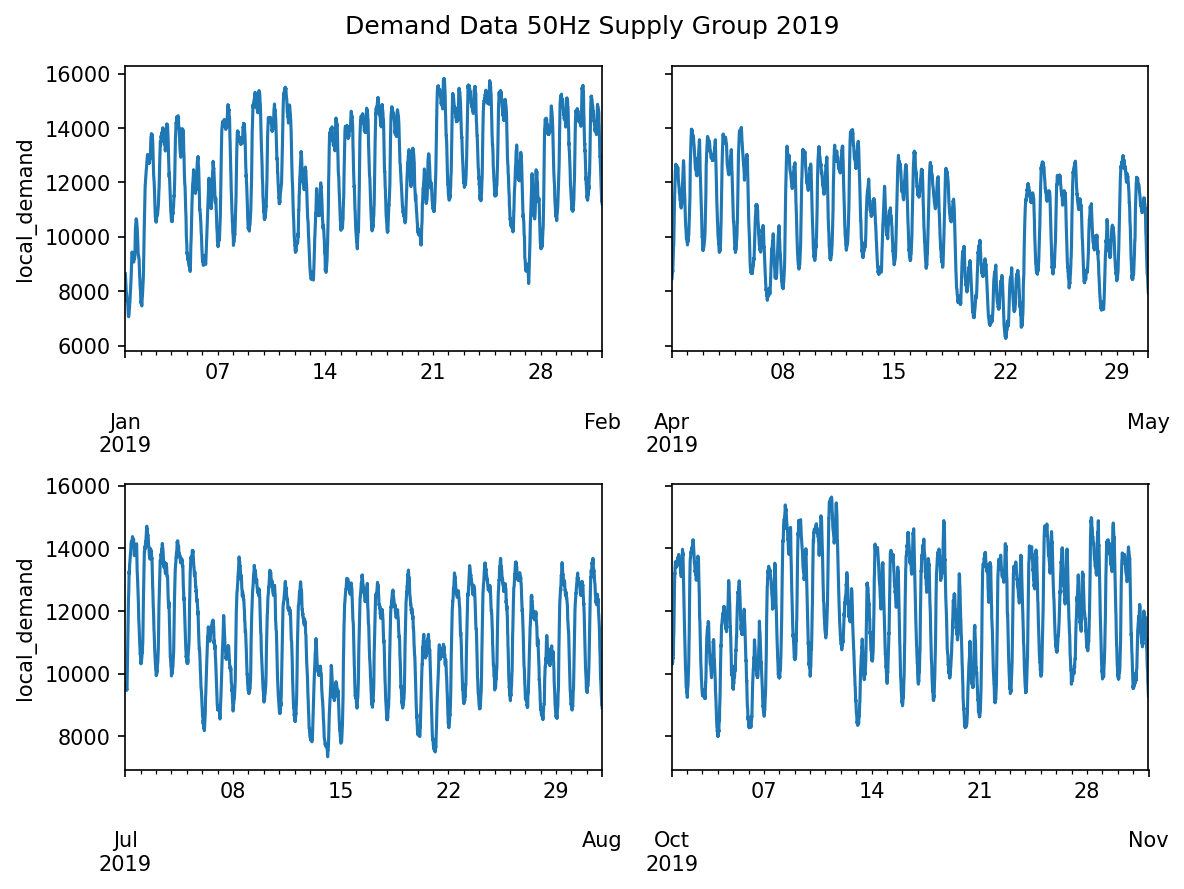

In [6]:
# Demand vs. time for 2019
fig, ax = plt.subplots(2, 2, dpi=150, figsize=(8, 6), sharey="row")

date_range = pd.date_range(
    start=UTC.localize(dt.datetime(2019, 1, 1)),
    end=UTC.localize(dt.datetime(2019, 12, 1)),
    freq="MS"
)

for i, (start, end) in enumerate(zip(date_range[::3], date_range[1::3])):
    
    # Slice df
    df_slice = df.loc[(df.index >= start) & (df.index <= end)]
    
    # Plot
    ax[i//2, i%2] = df_slice.plot(ax=ax[i//2, i%2], legend=False)
    ax[i//2, i%2].set_xlabel("")
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel("local_demand")


fig.suptitle("Demand Data 50Hz Supply Group 2019")        
fig.tight_layout();

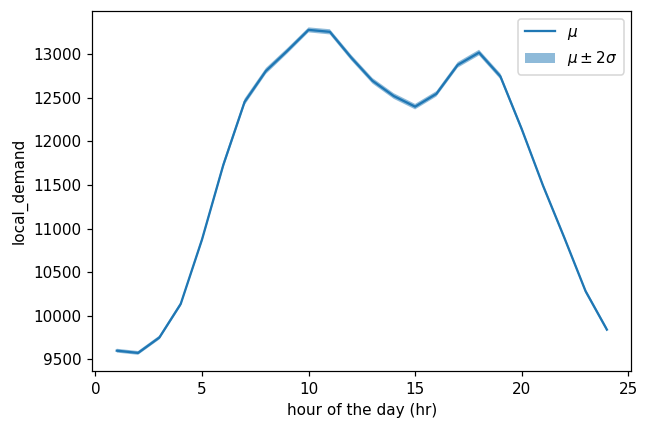

In [17]:
# Average consumption grouped by time of day
hourly_consumption_stats = df.groupby(df.index.hour).agg({
    "local_demand": ["mean", "sem"]
})

fig, ax = plt.subplots(1, 1, dpi=110)
mean = np.array(hourly_consumption_stats[("local_demand", "mean")])
err = np.array(hourly_consumption_stats[("local_demand", "sem")])
ax.plot(np.arange(1, 25), mean, label="$\mu$")
ax.fill_between(np.arange(1, 25), mean-2*err, mean+2*err, label="$\mu\pm2\sigma$", alpha=0.5, lw=0)

ax.legend()
ax.set_xlabel("hour of the day (hr)")
ax.set_ylabel("local_demand")
fig.tight_layout();

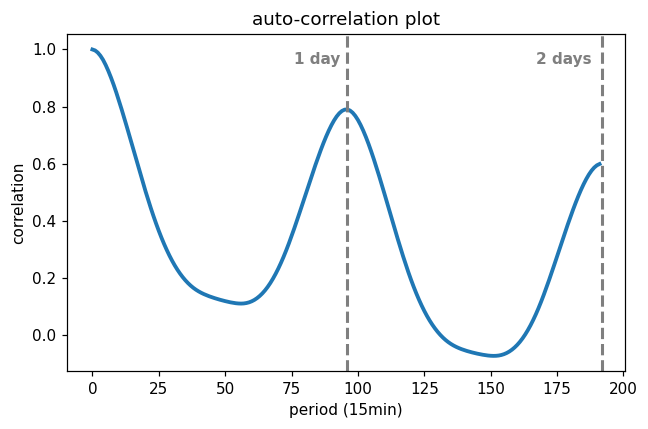

In [34]:
# Autocorrelation
fig, ax = plt.subplots(1, 1, dpi=110)
max_lags = 2 * 24 * 4  # 2 days 
ax.plot(
    np.arange(max_lags),
    np.array([df["local_demand"].autocorr(lag=lag) for lag in range(max_lags)]),
    lw=2.5
)

ax.axvline(1*24*4, color="tab:grey", lw=2, ls="--")
ax.axvline(2*24*4, color="tab:grey", lw=2, ls="--")
ax.annotate("1 day", (1*24*4-20, 0.95), color="tab:grey", weight="bold")
ax.annotate("2 days", (2*24*4-25, 0.95), color="tab:grey", weight="bold")
ax.set_xlabel("period (15min)")
ax.set_ylabel("correlation")
ax.set_title("auto-correlation plot")
fig.tight_layout();